In [181]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
import statistics
from matplotlib.ticker import PercentFormatter

In [187]:
#read in the prepped dataframe from create_columns 
dataframe = pd.read_csv('big_data_added_columns.csv')

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_9541/1048126044.py:1: DtypeWarning: Columns (23,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('big_data_added_columns.csv')


,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,date_of_creating_new_columns,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product,xbuy_days,xbuy_date
0,1.0,20278993.0,2021-10-09,1.0,503.99,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,542.0,NaN,543.0,NaN,NaN,relay,invest,1.0,2021-10-09
1,1.0,20278996.0,2021-10-03,1.0,2712.45,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN
2,1.0,20278999.0,NaN,NaN,NaN,2021-10-03,Active,9003.0,2023-04-02,1.21,...,2023-04-04,NaN,548.0,NaN,NaN,NaN,money,NaN,NaN,NaN
3,1.0,20279000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,NaN,NaN,548.0,NaN,NaN,relay,NaN,NaN,NaN
4,1.0,20279001.0,2021-10-04,2.0,376.95,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,547.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN
5,1.0,20279005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,NaN,NaN,NaN,547.0,NaN,loan,NaN,NaN,NaN
6,1.0,20279010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,NaN,NaN,NaN,547.0,NaN,loan,NaN,NaN,NaN
7,1.0,20279014.0,2021-10-03,1.0,1094.55,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,548.0,NaN,NaN,relay,invest,0.0,2021-10-03
8,1.0,20279020.0,2021-10-05,3.0,10343.57,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,546.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN
9,1.0,20279027.0,2021-10-03,1.0,3737.80,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,NaN,NaN,NaN,invest,NaN,NaN,NaN


In [23]:
dataframe['first_product'].value_counts()

relay     1912611
invest     503531
money      483923
loan       331784
credit      33898
Name: first_product, dtype: int64

In [63]:
dataframe['second_product'].value_counts()

money     431578
invest    393310
loan      144174
credit     48823
relay        654
Name: second_product, dtype: int64

In [242]:
#calculate the FICO bins
for i in range(dataframe.shape[0]):
    score = dataframe.at[i, 'RELAY_FICO']
    if(score < 580):
        dataframe.at[i, 'fico_bin'] = 'alow'
    elif(score >= 580 and score < 670):
        dataframe.at[i, 'fico_bin'] = 'bmid'
    elif(score >= 670):
        dataframe.at[i, 'fico_bin'] = 'chigh'
    else: dataframe.at[i, 'fico_bin'] = np.nan

dataframe = pd.get_dummies(dataframe, columns=['fico_bin'], drop_first=True)
dataframe['FICO_HIGH'] = dataframe['fico_bin_chigh']
dataframe['FICO_MID'] = dataframe['fico_bin_bmid']

# Models

In [251]:
#function to build a logistic regression model to predict from Relay to PL or Money
def analyze_relay(product):
    df = dataframe[dataframe['first_product'] == 'relay']
    cols = list(df.columns[14:21]) # relay columns
    cols.append('FICO_HIGH')
    cols.append('FICO_MID')

    # identify the desired target product
    if(product == 'PL'):
        drop_columns = ['PL_ACTIVE_IND']
        #cols.append('REL_LOAN_SQS')
        df['response'] = (dataframe['second_product'] == 'loan')

    if(product == 'Money'):
        drop_columns = ['BANKING_ACTIVE_IND']
        #cols.append('REL_MON_SQS')
        df['response'] = (dataframe['second_product'] == 'money')

    cols.append('response') # response variable
    df = df[cols]
    df = df.drop(columns=drop_columns)
    df.fillna(False,inplace=True)

    #downsample the data to balance the response variable (uses_money) (majority are users that do not use money and only use 1 product)
    # Separate majority class (uses_money = 0 and num_products = 1)
    data_majority = df[df['response'] == False]
    data_minority = df[df['response'] == True]

    # Downsample majority class
    data_majority_downsampled = resample(data_majority, 
                                        replace=False,    # sample without replacement
                                        n_samples=len(data_minority),     # to match minority class
                                        random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    data_downsampled = pd.concat([data_majority_downsampled, data_minority])

    # model
    X_train, X_test, y_train, y_test = train_test_split(data_downsampled[data_downsampled.columns[:-1]], data_downsampled['response'], test_size=0.33, random_state=34)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # check the accuracy
    accuracy = "ACCURACY: "+str(accuracy_score(y_test, y_pred))

    # find coefficients
    coefs = pd.DataFrame(zip(X_train.columns, np.transpose(model.coef_)), columns=['features', 'coef']) 

    # normalizing
    for i in range(coefs.shape[0]):
        coefs.iloc[i, 1] = 100 * (math.exp(coefs.iloc[i, 1]) - 1)

    # psuedo r^2
    fitted_values = model.predict(X_train)
    r2 = "R2: "+str(np.corrcoef(y_train, fitted_values)[0][1])

    return coefs, accuracy, model, df, r2



In [252]:
#sample code to look at model accuracy and output for PL
pl = analyze_relay('PL')
print(pl[1], pl[4])
pl[0]

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_9541/3315405788.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = (dataframe['second_product'] == 'loan')


ACCURACY: 0.8113414203274055 R2: 0.6360288428679596


,features,coef
0,SL_ACTIVE_IND,-51.028337
1,MORTGAGE_ACTIVE_IND,17.672035
2,BANKING_ACTIVE_IND,-79.06308
3,INVEST_ACTIVE_IND,-72.537857
4,CC_ACTIVE_IND,-9.477284
5,CSM_ACTIVE_IND,-23.122588
6,FICO_HIGH,65853.555049
7,FICO_MID,11958.772727


potential issue with people being able to start relay tracking after they open the product of choice. so like they start tracking an additional product after they have already opened the app

In [253]:
#sample code to look at model accurcay and output for Money
money = analyze_relay('Money')
print(money[1], money[4])
money[0]

/var/folders/cw/hgq_4j310_x0341w_fpbn62m0000gp/T/ipykernel_9541/3315405788.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['response'] = (dataframe['second_product'] == 'money')


ACCURACY: 0.6397851476173709 R2: 0.28497046449039976


,features,coef
0,SL_ACTIVE_IND,-62.431542
1,PL_ACTIVE_IND,-67.816336
2,MORTGAGE_ACTIVE_IND,-37.100026
3,INVEST_ACTIVE_IND,130.415771
4,CC_ACTIVE_IND,56.149921
5,CSM_ACTIVE_IND,-0.575638
6,FICO_HIGH,124.427963
7,FICO_MID,121.462379


# Crossbuy Visualizations

In [29]:
#dataframe to look specifically at xbuy customers
xbuy = dataframe[pd.isnull(dataframe['xbuy_days']) != True]

,ROW_NUM,USER_ID,INV_OPEN_DATE,INV_NUM_ACCOUNTS,INV_ACC_BAL,MONEY_ACCOUNT_OPEN_DATE,MONEY_ACCOUNT_STATUS,MONEY_FICO,MONEY_DATA_UPDATE_DATE,MONEY_TOTAL_BALANCE,...,date_of_creating_new_columns,days_with_invest,days_with_money,days_with_relay,days_with_loan,days_with_credit,first_product,second_product,xbuy_days,xbuy_date
0,1.0,20278993.0,2021-10-09,1.0,503.99,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,542.0,NaN,543.0,NaN,NaN,relay,invest,1.0,2021-10-09
7,1.0,20279014.0,2021-10-03,1.0,1094.55,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,548.0,NaN,NaN,relay,invest,0.0,2021-10-03
15,1.0,20279040.0,2021-10-03,2.0,317619.37,2021-10-11,Active,647.0,2023-04-02,0.29,...,2023-04-04,548.0,540.0,548.0,519.0,NaN,relay,invest,0.0,2021-10-03
16,1.0,20279045.0,2021-10-07,2.0,5458.79,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,544.0,NaN,545.0,NaN,NaN,relay,invest,1.0,2021-10-07
17,1.0,20279053.0,NaN,NaN,NaN,2021-11-17,Active,456.0,2023-04-02,0.90,...,2023-04-04,NaN,503.0,503.0,NaN,NaN,relay,money,0.0,2021-11-17
19,1.0,20279070.0,2021-10-03,4.0,5413.05,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,548.0,NaN,548.0,NaN,NaN,relay,invest,0.0,2021-10-03
20,1.0,20279076.0,2021-10-05,2.0,92795.29,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,546.0,NaN,546.0,NaN,NaN,relay,invest,0.0,2021-10-05
21,1.0,20279092.0,NaN,NaN,NaN,2022-02-06,Active,800.0,2023-04-02,50.00,...,2023-04-04,NaN,422.0,548.0,NaN,NaN,relay,money,126.0,2022-02-06
22,1.0,20279094.0,2021-10-26,2.0,6470.37,NaN,NaN,NaN,NaN,NaN,...,2023-04-04,525.0,NaN,548.0,NaN,NaN,relay,invest,23.0,2021-10-26
23,1.0,20279096.0,NaN,NaN,NaN,2021-10-12,Active,NaN,2023-04-02,777.53,...,2023-04-04,NaN,539.0,548.0,265.0,NaN,relay,money,9.0,2021-10-12


In [82]:
#dataframes for customers that had relay as a first product and did or didn't crossbuy
with_xbuy = dataframe[(dataframe['first_product'] == 'relay') & (dataframe['second_product'].isnull() == False)]
no_xbuy = dataframe[(dataframe['first_product'] == 'relay') & (dataframe['second_product'].isnull())]

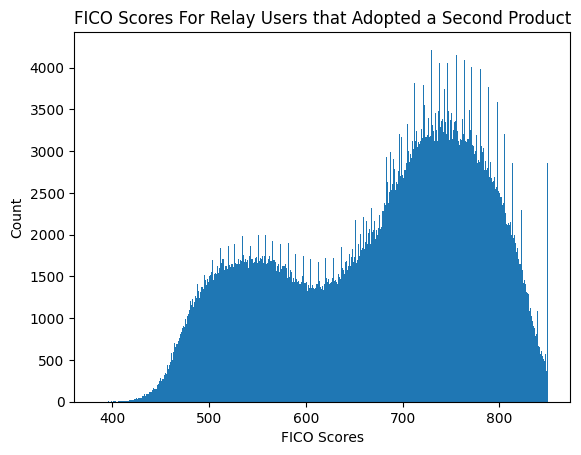

In [216]:
#plot FICO scores for users that crossbought
plt.hist(x=with_xbuy['RELAY_FICO'], bins=466)
plt.title('FICO Scores For Relay Users that Adopted a Second Product')
plt.xlabel('FICO Scores')
plt.ylabel('Count')
plt.show()

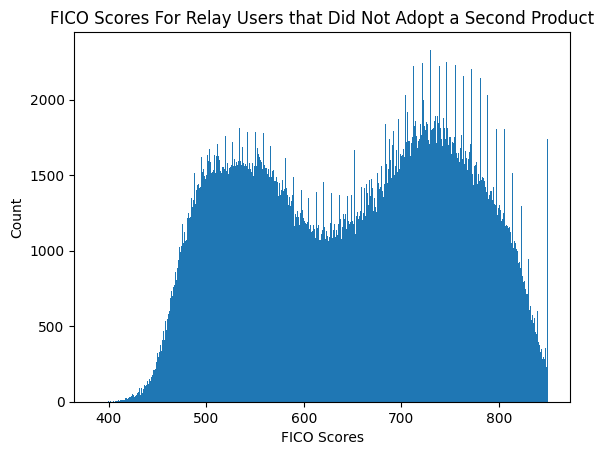

In [215]:
#plot FICO scores for users that did not crossbuy
plt.hist(x=no_xbuy['RELAY_FICO'], bins=462)
plt.title('FICO Scores For Relay Users that Did Not Adopt a Second Product')
plt.xlabel('FICO Scores')
plt.ylabel('Count')
plt.show()

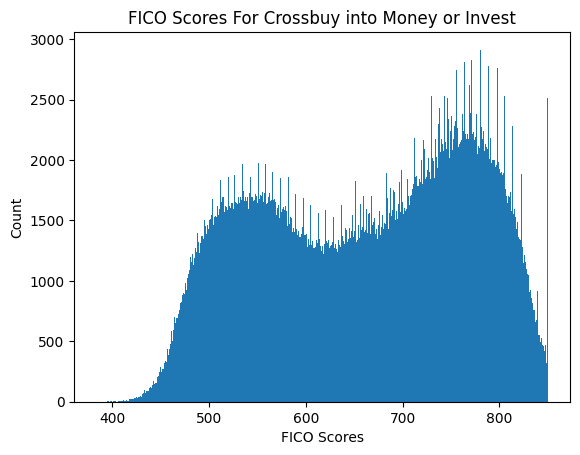

In [257]:
#plot FICO scores for people that crossbought into products without a FICO requirement
no_fico_req = with_xbuy[(with_xbuy['second_product'] == 'money') | (with_xbuy['second_product'] == 'invest')]

plt.hist(x=no_fico_req['RELAY_FICO'], bins=466)
plt.title('FICO Scores For Crossbuy into Money or Invest')
plt.xlabel('FICO Scores')
plt.ylabel('Count')
plt.show()

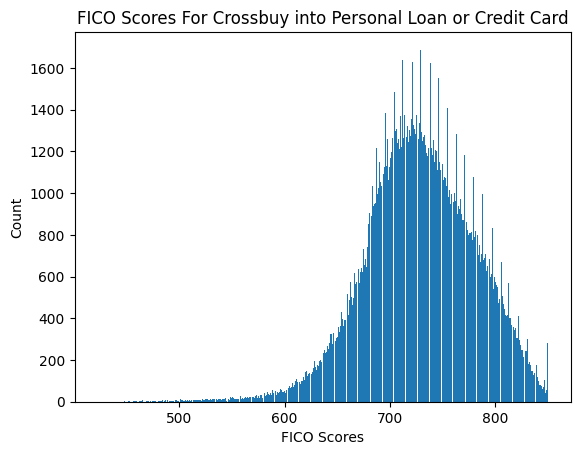

In [258]:
#plot FICO scores for people that crossbought into products with a FICO requirement
fico_req = with_xbuy[(with_xbuy['second_product'] == 'loan') | (with_xbuy['second_product'] == 'credit')]

plt.hist(x=fico_req['RELAY_FICO'], bins=466)
plt.title('FICO Scores For Crossbuy into Personal Loan or Credit Card')
plt.xlabel('FICO Scores')
plt.ylabel('Count')
plt.show()

In [256]:
# look at quantiles of FICO scores
fico_req['RELAY_FICO'].quantile([0.025, 0.975])
fico_req['RELAY_FICO'].quantile([0.17, 0.83])

0.17    683.0
0.83    780.0
Name: RELAY_FICO, dtype: float64

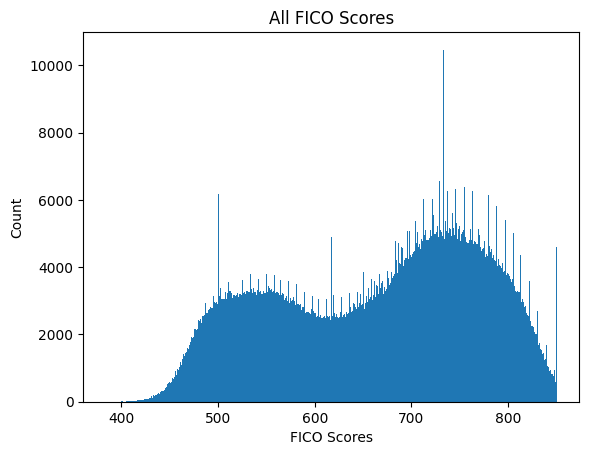

In [204]:
#plot of all FICO scores
plt.hist(x=dataframe['RELAY_FICO'], bins=462)
plt.title('All FICO Scores')
plt.xlabel('FICO Scores')
plt.ylabel('Count')
plt.show()

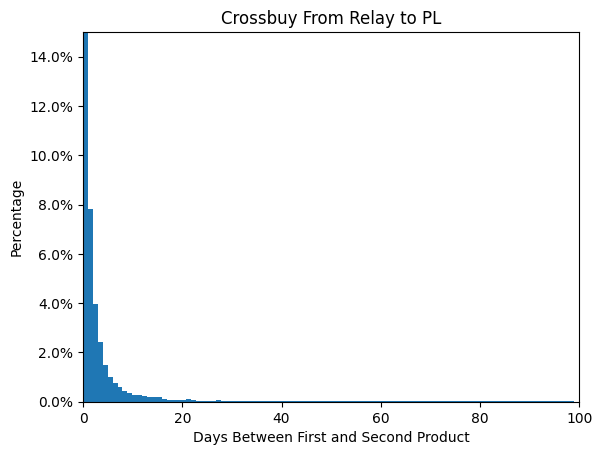

In [231]:
#plot crossbuy from Relay to PL
relay_pl = xbuy[xbuy['first_product'] == 'relay']
relay_pl = relay_pl[relay_pl['second_product'] == 'loan']
relay_pl = relay_pl[relay_pl['xbuy_days'] < 100]
plt.hist(x=relay_pl['xbuy_days'], weights=np.ones(len(relay_pl['xbuy_days'])) / len(relay_pl['xbuy_days']), bins=100)
plt.plot(axis='y')
plt.title('Crossbuy From Relay to PL')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
#plt.ylim(top=.15)                                                          #uncomment this to get a better look at what's going on after the first day
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

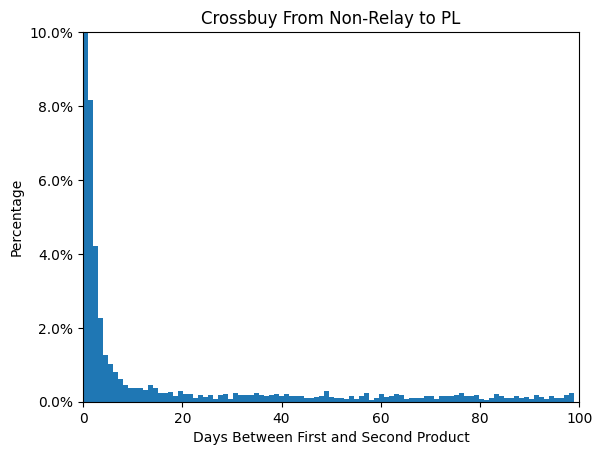

In [233]:
#plot crossbuy from non-Relay and products to PL
relay_pl = xbuy[xbuy['first_product'] != 'relay']
relay_pl =  relay_pl[relay_pl['second_product'] == 'loan']
relay_pl = relay_pl[(relay_pl['xbuy_days'] < 100)]
plt.hist(x=relay_pl['xbuy_days'], weights=np.ones(len(relay_pl['xbuy_days'])) / len(relay_pl['xbuy_days']), bins=98)
plt.plot(axis='y')
plt.title('Crossbuy From Non-Relay to PL')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
#plt.ylim(top=0.1)                                                          #uncomment this to get a better look at what's going on after the first day
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

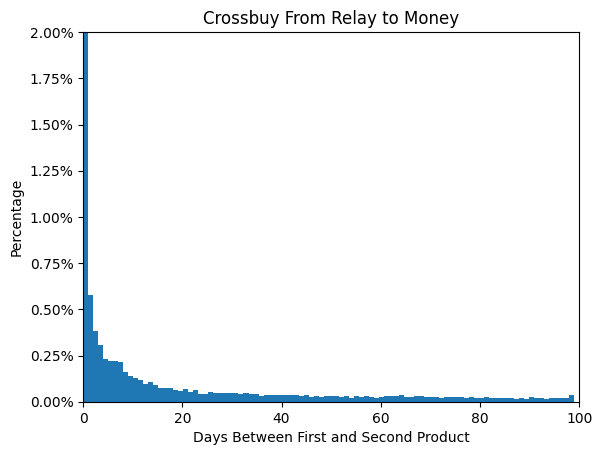

In [230]:
#plot crossbuy from Relay to Money
relay_money = xbuy[xbuy['first_product'] == 'relay']
relay_money = relay_money[relay_money['second_product'] == 'money']
relay_money = relay_money[(relay_money['xbuy_days'] < 100)]
plt.hist(x=relay_money['xbuy_days'], weights=np.ones(len(relay_money['xbuy_days'])) / len(relay_money['xbuy_days']), bins=98)
plt.plot(axis='y')
plt.title('Crossbuy From Relay to Money')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
#plt.ylim(top=0.02)                                             #uncomment this to get a better look at what's going on after the first day
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

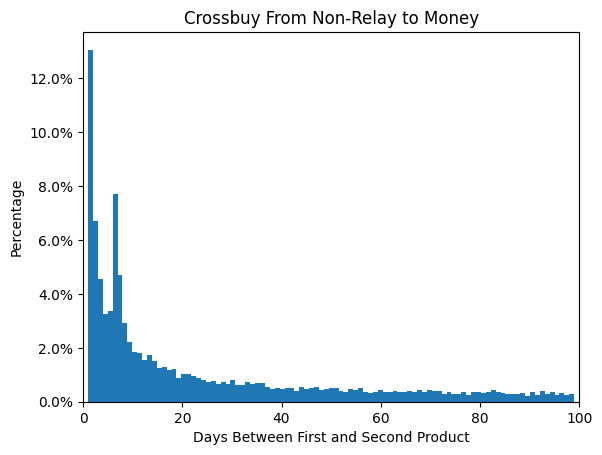

In [221]:
#crossbuy from non-Relay products to Money
relay_money = xbuy[xbuy['first_product'] != 'relay']
relay_money = relay_money[relay_money['second_product'] == 'money']
relay_money = relay_money[(relay_money['xbuy_days'] < 100)]
plt.hist(x=relay_money['xbuy_days'], weights=np.ones(len(relay_money['xbuy_days'])) / len(relay_money['xbuy_days']), bins=99)
plt.plot(axis='y')
plt.title('Crossbuy From Non-Relay to Money')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

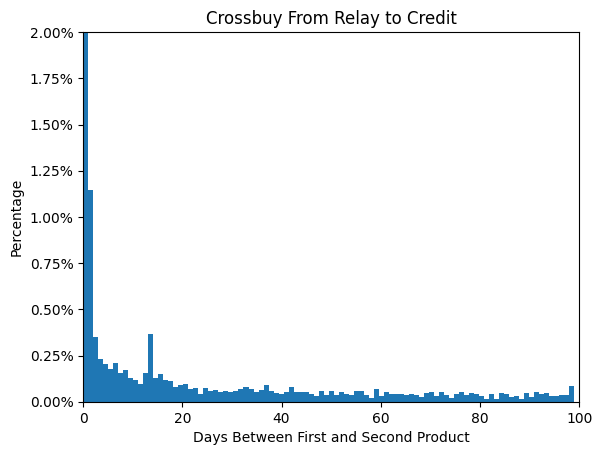

In [236]:
#crossbuy from Relay to Credit Card
relay_credit = xbuy[xbuy['first_product'] == 'relay']
relay_credit = relay_credit[relay_credit['second_product'] == 'credit']
relay_credit = relay_credit[(relay_credit['xbuy_days'] < 100)]
plt.hist(x=relay_credit['xbuy_days'], weights=np.ones(len(relay_credit['xbuy_days'])) / len(relay_credit['xbuy_days']), bins=98)
plt.plot(axis='y')
plt.title('Crossbuy From Relay to Credit')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
#plt.ylim(top=0.02)                                                     #uncomment this to get a better look at what's going on after the first day
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

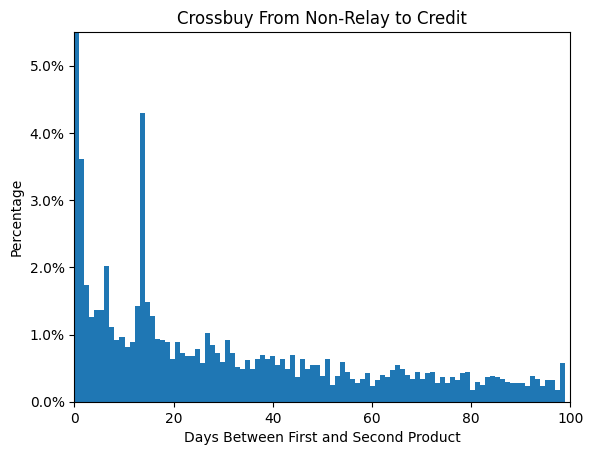

In [237]:
#crossbuy from non-Relay products to Credit Card
relay_credit = xbuy[xbuy['first_product'] != 'relay']
relay_credit = relay_credit[relay_credit['second_product'] == 'credit']
relay_credit = relay_credit[(relay_credit['xbuy_days'] < 100)]
plt.hist(x=relay_credit['xbuy_days'], weights=np.ones(len(relay_credit['xbuy_days'])) / len(relay_credit['xbuy_days']), bins=98)
plt.plot(axis='y')
plt.title('Crossbuy From Non-Relay to Credit')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
#plt.ylim(top = 0.055)                                                  #uncomment this to get a better look at what's going on after the first day
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

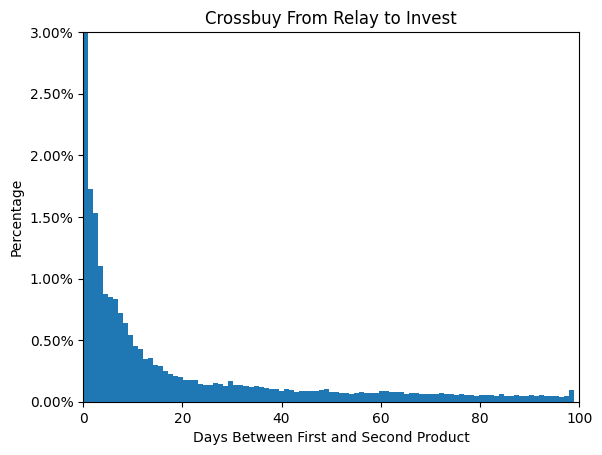

In [238]:
#crossbuy from Relay to Invest
relay_invest = xbuy[xbuy['first_product'] == 'relay']
relay_invest = relay_invest[relay_invest['second_product'] == 'invest']
relay_invest = relay_invest[(relay_invest['xbuy_days'] < 100)]
plt.hist(x=relay_invest['xbuy_days'], weights=np.ones(len(relay_invest['xbuy_days'])) / len(relay_invest['xbuy_days']), bins=98)
plt.plot(axis='y')
plt.title('Crossbuy From Relay to Invest')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
#plt.ylim(top=0.03)                                             #uncomment this to get a better look at what's going on after the first day
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

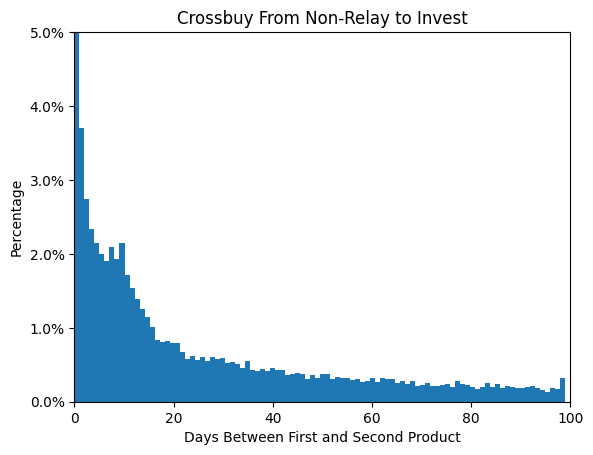

In [239]:
#crossbuy from non-Relay to Invest
relay_invest = xbuy[xbuy['first_product'] != 'relay']
relay_invest = relay_invest[relay_invest['second_product'] == 'invest']
relay_invest = relay_invest[relay_invest['xbuy_days'] < 100]
plt.hist(x=relay_invest['xbuy_days'], weights=np.ones(len(relay_invest['xbuy_days'])) / len(relay_invest['xbuy_days']), bins=98)
plt.plot(axis='y')
plt.title('Crossbuy From Non-Relay to Invest')
plt.xlabel('Days Between First and Second Product')
plt.ylabel('Percentage')
plt.xlim(left=0, right=100)
#plt.ylim(top=0.05)                                                         #uncomment this to get a better look at what's going on after the first day
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [21]:
statistics.median(relay_pl['xbuy_days'])

0.0